**Brief:** this notebook performs fits operations on healpix, specifically it converts from the HealPix format into the WCS Zenith-Equal-Area projection; 

In [1]:
#hpxFile = "COM_CompMap_Dust-GNILC-Model-Opacity_2048_R2.01.fits"
#hpxComm = "Thermal dust optical depth at 353 GHz, Planck 2015 results"

hpxFile = "COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.01.fits"
hpxComm = "Thermal dust temperature, Planck 2015 results"

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy import units as u
from astroquery.ned import Ned as NED
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS

In [4]:
result_table = NED.query_object("Coma Cluster")
ra, dec = result_table[0][2], result_table[0][3]
c = SkyCoord(ra, dec, unit="deg", frame='fk5') # center of Coma cluster according to NED

In [5]:
NHI_map = fits.open("NHI_ZEA.fits")
wcs = WCS(NHI_map[0].header).dropaxis(2)
NHI_map[0].header = fits.Header.fromstring(wcs.to_header_string())
NHI_map[0].header.set("SIMPLE",True)
NHI_map[0].verify('fix')
# tmp.fits contains the correct header info needed for the reprojection of the map from HealPix.
dpix = np.abs(wcs.wcs.cdelt[0]) * u.deg
dist = int(np.floor(40*u.deg / dpix)) # 30 deg cut-out

 [astropy.io.fits.verify]


In [6]:
from reproject import reproject_from_healpix

In [7]:
hpxName = hpxFile.split(".fits")[0]
hpx_file = fits.open(hpxFile)
print hpx_file

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x113c594d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x113b876d0>]


In [8]:
# reproject does not work out of the box.
array, footprint = reproject_from_healpix(hpxFile,wcs,shape_out=np.shape(NHI_map[0].data),hdu_in=1)

IndexError: index -4398042316800 is out of bounds for axis 1 with size 50331648

In [9]:
# the error seems to be related to the indexing of the healpix data, HealPix seems to expect pixels to start from 1, but it seemingly starts from 0.
fits.getheader(hpxFile,1)['lastpix']

50331647

In [10]:
# FIX: following the unit tests: https://programtalk.com/vs2/?source=python/985/reproject/reproject/healpix/high_level.py, I can reverse engineer the wrapper and build my own. Seemingly this works.
from reproject.healpix.utils import parse_input_healpix_data
from reproject.healpix.core import healpix_to_image
from reproject.utils import parse_output_projection

In [11]:
array_in, coordsys_in, nested = parse_input_healpix_data(hpx_file[1])
shape_out = np.shape(NHI_map[0].data)
wcs_out, shape_out = parse_output_projection(wcs,shape_out)

In [12]:
array, footprint = healpix_to_image(array_in, coordsys_in, wcs_out, shape_out, nested=False)

In [13]:
hdu = fits.PrimaryHDU(data=array)
hdu.header = fits.Header.fromstring(wcs.to_header_string())
hdu.verify('fix')
hdu.writeto("%s_ZEA.fits"%hpxName,overwrite=True)

In [14]:
from astropy import nddata

In [15]:
cutout = nddata.Cutout2D(hdu.data,c,dist,wcs)
# remove nan's
mask = np.where(np.isnan(cutout.data))
cutout.data[mask] = 1e-55
neg_mask = np.where(cutout.data < 0)
cutout.data[neg_mask] = 1e-55

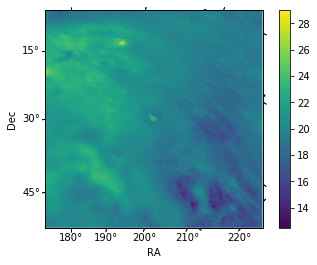

In [16]:
# let's take a look
fig = plt.figure()
fig.add_subplot(111, projection=cutout.wcs)
cm = plt.imshow(cutout.data, origin='lower', cmap=plt.cm.viridis)
#cm = plt.imshow(cutout.data, origin='lower', cmap=plt.cm.viridis)
plt.colorbar(cm)
plt.xlabel('RA')
plt.ylabel('Dec')

In [17]:
# write out to fits
hdr = (cutout.wcs).to_header()
hdr['COMMENT']=hpxComm
hdu = fits.PrimaryHDU(cutout.data,header=hdr)
hdu.writeto("%s_ZEA_cutout.fits"%hpxName,overwrite=True)

In [18]:
# reminder: in order to be used by the science tools - 
# and to separate spatial from spectral map, the integral over the map should be 1.
# 
def verify(fitsfile,eps=1e-6):
    x = fits.open(fitsfile)
    ps=np.abs(np.radians(x[0].header['cdelt1']))
    sa=ps**2
    res = x[0].data.sum()*sa
    neg_mask = np.where(x[0].data < 0)
    assert np.size(neg_mask) == 0, "verification failed, negative pixels found: %s"%str(neg_mask)
    assert np.abs(res - 1) <= eps, "Integral over pixels: %1.1e != 1, verification failed"%res
    return True
    


In [19]:
# normalize to be an intensity map instead
x = fits.open("%s_ZEA_cutout.fits"%hpxName)
# remove negative pixel values
mask = np.where(x[0].data < 0)
assert np.size(mask) == 0, "non-zero pixels found"
sa = np.abs(np.radians(x[0].header['cdelt1']))**2
res = x[0].data.sum()*sa
x[0].data /= res
x.writeto("%s_ZEA_cutout_normalized.fits"%hpxName,overwrite=True)
assert verify("%s_ZEA_cutout_normalized.fits"%hpxName), "verification failed"